In [1]:
from pathlib import Path
import torch
import numpy as np
import os
import pandas as pd

from torch import cuda
import pytorch_lightning as pl
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

os.chdir("..")
from utils import io
from models import SegmentationModel

In [8]:
lv_thresholds=[1, 5, 10, 20, 50, 100, 150]
prob_th = []
y_prob_th = []
dates=[]
prob = []
os.chdir(f"/home/students/s265780/rainfall-prob-sigmoid/rainfall-prediction/proba/1/")
pred_date = os.scandir()
for file in pred_date:
    dates.append(file.name[4:12])
os.chdir("..")
dates = ['20200519',  #split_8 seed 42
 '20220423',
 '20180611',
 '20191127',
 '20201207',
 '20191104',
 '20210708',
 '20200824',
 '20200501',
 '20191120',
 '20181106',
 '20181029',
 '20190424',
 '20210716',
 '20200710',
 '20190807',
 '20180603',
 '20191119',
 '20180831',
 '20220401',
 '20200510',
 '20191107',
 '20220331',
 '20200312',
 '20210506',
 '20190525',
 '20180720',
 '20210530',
 '20210623',
 '20190725',
 '20220506',
 '20220425',
 '20200815',
 '20190610',
 '20191121',
 '20211110',
 '20220508',
 '20200513',
 '20200730',
 '20181108',
 '20200816',
 '20220524',
 '20190811',
 '20200907',
 '20180531']

In [9]:
os.chdir("..")
model = SegmentationModel.load_from_checkpoint(Path("/home/students/s265780/rainfall-prob-sigmoid/rainfall-prediction/lightning_logs/unet/split_8/epoch=28-train_loss=0.21.ckpt"))
model.eval();

input_path = Path("/home/students/s265780/data/24h_10mmMAX_OI")
seed=42
n_split=8
#dates = pd.read_csv(input_path / "split/cluster_all_dates.csv", sep=";")
#skf = StratifiedKFold(n_splits=9, random_state=seed, shuffle=True)
#train_index, test_index = list(skf.split(dates, dates.NAME))[n_split]
#val_index, train_index = np.split(train_index, [len(test_index)])
#train_dates = dates.iloc[train_index].DATA.values
#val_dates = dates.iloc[val_index].DATA.values
#test_dates = dates.iloc[test_index].DATA.values

indices_one, indices_zero, mask = io.get_mask_indices(input_path, True) #why False?
case_study_max=483.717752
available_models = ["bol00", "e1000", "c2200", "c5m00"]
x, y, in_features, out_features = io.load_data(input_path, dates, case_study_max, indices_one, indices_zero, available_models)

In [10]:
lv_thresholds=[1, 5, 10, 20, 50, 100, 150]
prob_path = Path("proba/")
prob_th = []
y_prob_th = []
for lv in lv_thresholds:
    (prob_path/str(lv)).mkdir(exist_ok=True)
    prob = []
    for date in dates:
        df = pd.read_csv(prob_path/f"{lv}/pred{date}.csv", header=None)
        prob.append(df.values)
    probs = np.stack(prob)
    prob_th.append(probs)
    y_prob_th.append(y*case_study_max > lv)
probs_th = np.stack(prob_th)
y_prob_th = np.stack(y_prob_th)

In [11]:
#x = x[0:50] #cut dates or out of memory
model.cuda()
with torch.inference_mode():
    y_logit, y_prob = model(torch.from_numpy(x).cuda(), None)
y_hat = y_logit.squeeze().cpu().numpy()
y_hat_prob = y_prob.cpu().numpy()

Text(0.5, 1.0, 'ground_thruth')

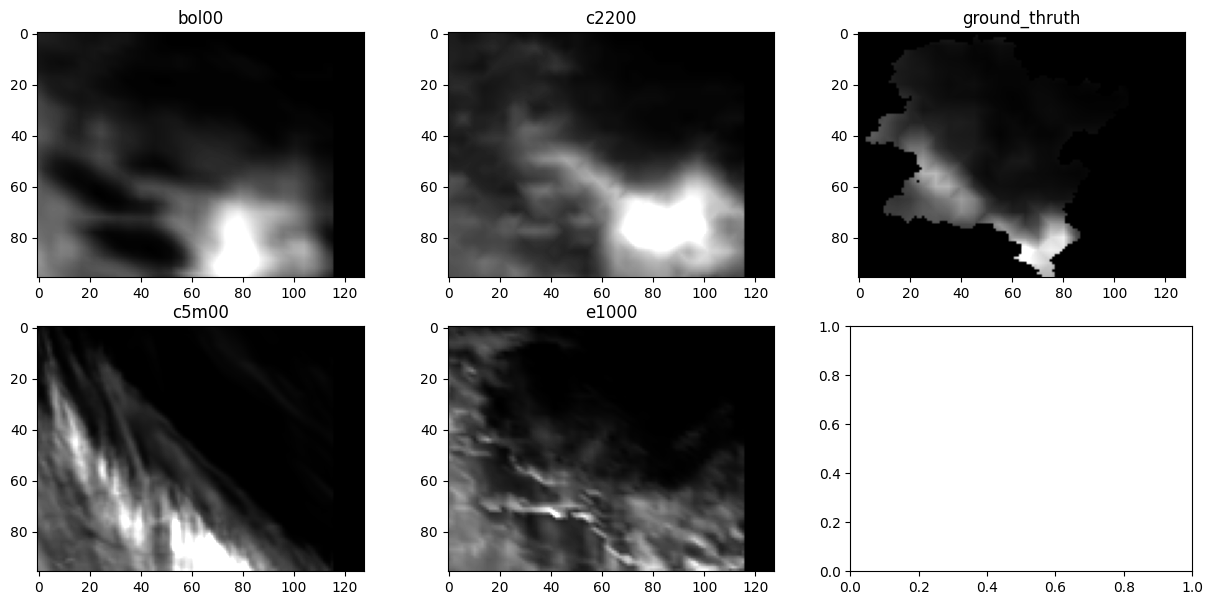

In [56]:
m=33
norm='linear'
vmin=0
vmax=1/5
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs[0, 0].imshow(x[m][0], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 0].set_title('bol00')
axs[0, 1].imshow(x[m][1], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 1].set_title('c2200')
axs[1, 0].imshow(x[m][2], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 0].set_title('c5m00')
axs[1, 1].imshow(x[m][3], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[1, 1].set_title('e1000')
axs[0, 2].imshow(y[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
axs[0, 2].set_title('ground_thruth')
#axs[1, 2].imshow(y_hat[m], cmap='gray', norm=norm, vmin=vmin, vmax=vmax)
#axs[1, 2].set_title('model_pred')

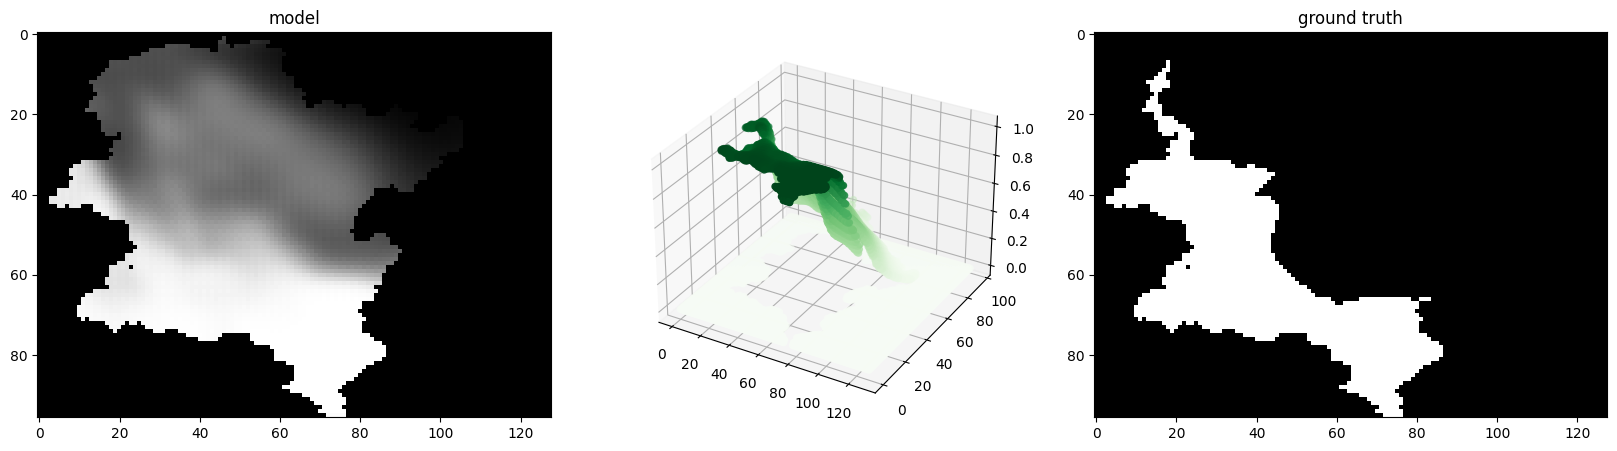

In [55]:
soglia=2
m=33

fig, axs = plt.subplots(1, 2, figsize=(25, 5))
axs[0].imshow(probs_th[soglia][m], vmax=1, vmin=0, cmap="gray")
axs[0].set_title("model")
axs[1].imshow(y_prob_th[soglia][m], cmap="gray")
axs[1].set_title("ground truth")

ax = plt.axes(projection='3d')
xdata = np.linspace(0, 128, 128)
ydata = np.linspace(96, 0, 96)
xx,yy=np.meshgrid(xdata,ydata)
ax.scatter3D(xx, yy, y_hat_prob[m][soglia], c=probs_th[soglia][m], cmap='Greens');

In [14]:
soglia=4
probs = probs_th[soglia]
bins=np.linspace(0.1, 1, 10)
prob_bins = np.digitize(probs, bins)
y_bins = np.where(y*case_study_max > lv_thresholds[soglia], 1 ,0)
#plt.imshow(prob_bins)
bins

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [15]:
p_emp = []
p_emp_var = []
p = []
size=[]
for i in range(len(bins)):
    indx = np.where((prob_bins==i) & (mask==1))
    p.append(probs[indx].mean())
    p_emp.append(y_bins[indx].mean())
    p_emp_var.append(y_bins[indx].var())
    size.append(len(indx[0])/200)

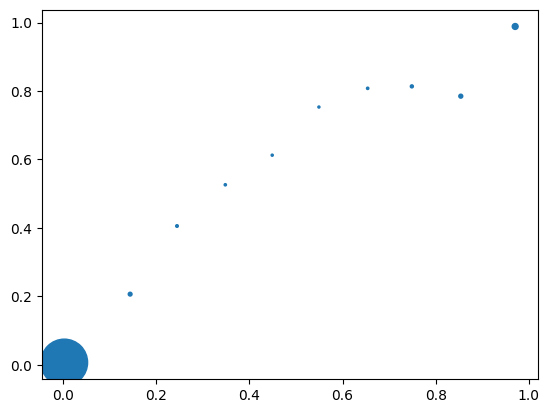

In [16]:
plt.scatter(p, p_emp, s=size)

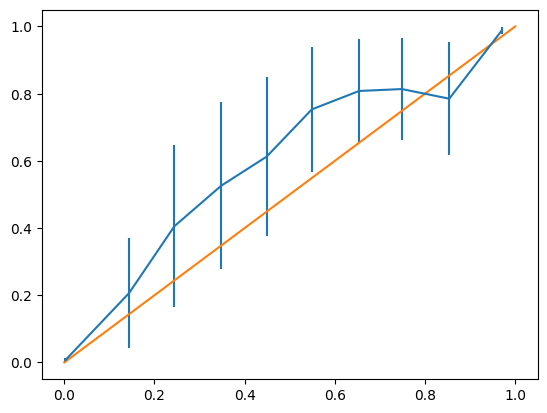

In [17]:
plt.errorbar(p, p_emp, yerr=p_emp_var)
plt.plot([0, 1], [0, 1])

In [18]:
from sklearn.calibration import calibration_curve

In [19]:
n_bins=10
soglia=1
x_, y_ = calibration_curve(y_prob_th[soglia].flatten(), probs_th[soglia].flatten(), n_bins=n_bins, strategy='quantile')
ece = np.mean(np.abs(x_ - y_))
ece

0.0362573787841081

In [20]:
eps=1e-10
probs = probs_th[soglia,:,mask==1].flatten()
y_true_gt=y_prob_th[soglia,:,mask==1].flatten()
kl_prob_gt = -np.mean(probs * np.log((y_true_gt + eps) / (probs + eps)) \
                      +(1 - probs) * np.log((1 - y_true_gt + eps) / (1-probs + eps)))
kl_prob_gt

5.115732546566147